In [9]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
import math

### Load Data

In [10]:
# The directory that I store my csv files with the embeddings.
embeddings_directory = r"C:\Nikolaos Sintoris\Education\MEng CSE - UOI\Diploma Thesis\Scanning\Train results\ResNet50 SimCLR\Layer 2\Embeddings"

# Load numpy array from a csv file
training_data_np = np.loadtxt(embeddings_directory + '\\training_data.csv', delimiter = ',')
training_data = torch.from_numpy(training_data_np) # It does not create a copy. Uses the same memory.
training_data = training_data.float()
print("Training data shape: ", training_data.shape)

actual_training_labels_np = np.loadtxt(embeddings_directory + '\\actual_training_labels.csv', delimiter = ',')
actual_training_labels = torch.from_numpy(actual_training_labels_np) # It does not create a copy. Uses the same memory.
actual_training_labels = actual_training_labels.long()
print("Actual training labels shape: ", actual_training_labels.shape)

validation_data_np = np.loadtxt(embeddings_directory + '\\validation_data.csv', delimiter = ',')
validation_data = torch.from_numpy(validation_data_np) # It does not create a copy. Uses the same memory.
validation_data = validation_data.float()
print("Validation data shape: ", validation_data.shape)

actual_validation_labels_np = np.loadtxt(embeddings_directory + '\\actual_validation_labels.csv', delimiter = ',')
actual_validation_labels = torch.from_numpy(actual_validation_labels_np) # It does not create a copy. Uses the same memory.
actual_validation_labels = actual_validation_labels.long()
print("Actual validation labels shape: ", actual_validation_labels.shape)

Training data shape:  torch.Size([8095, 512])
Actual training labels shape:  torch.Size([8095])
Validation data shape:  torch.Size([3469, 512])
Actual validation labels shape:  torch.Size([3469])


### Create a Feedforward Neural Network

In [11]:
# Create a feedforward NN with:
# 1 hidden layer with self.first_hidden_size neurons and Relu activation function.
# 1 output layer with 3 neurons and softmax activation function.
class MLP(torch.nn.Module):
        def __init__(self, input_size, first_hidden_size):
            super(MLP, self).__init__()
            self.input_size = input_size
            self.first_hidden_size  = first_hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.first_hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.first_hidden_size, 3)
            self.softmax = torch.nn.Softmax(dim = 1)
            
            
        def forward(self, x):
            first_hidden = self.fc1(x)
            first_relu = self.relu(first_hidden)
            
            output = self.fc2(first_relu)
            output = self.softmax(output)
            return output

In [12]:
input_layer_size = training_data.shape[1]
first_hidden_layer_size = round(math.sqrt(input_layer_size * 3)) #28 - 39 - 55 - 78

my_model = MLP(input_layer_size, first_hidden_layer_size)

loss_function = torch.nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(my_model.parameters(), lr = learning_rate)

### Train model

In [13]:
# Computes the accuracy.
def compute_accuracy(predictions, labels):
    # Take the max value and the max index of every vector in predictions.
    max_values, max_indexes = torch.max(predictions.data, 1)
    # Compute the accuracy.
    accuracy = (((max_indexes == labels).sum().item()) / labels.shape[0]) * 100
    return accuracy

def train_model(model, data, actual_labels):
    # Set train mode.
    model.train()
    
    # Sets the gradients to zero before we start backpropagation
    optimizer.zero_grad()
    
    # Forward pass - compute labels.
    predicted_training_labels = model(data)
    
    # Calculate cross entropy loss.
    loss = loss_function(predicted_training_labels, actual_labels)
    
    # Calculate accuracy.
    accuracy = compute_accuracy(predicted_training_labels, actual_labels)
    
    # Computes the gradients.
    loss.backward()
    
    # Update the parameters.
    optimizer.step()
    
    return loss.item()
    
def test_model(model, data, actual_labels):
    # Set evaluation mode.
    model.eval()
    
    # Compute predicted labels.
    predicted_test_labels = model(data)
    
    # Compute accuracy.
    final_accuracy = compute_accuracy(predicted_test_labels, actual_labels)
    
    return final_accuracy, predicted_test_labels

In [14]:
# I have 10000 epochs.
# In each epoch, I train the model.
# Every 10 epochs I compute the accuracy on the validation test.
# I save the model with the maximum validation accuracy.

best_model_directory = r"C:\Nikolaos Sintoris\Education\MEng CSE - UOI\Diploma Thesis\Scanning\Train results\ResNet50 SimCLR\Layer 2\Best model"

if not os.path.exists(best_model_directory):
    os.makedirs(best_model_directory)

number_of_epochs = 10000
epoch_list = [x for x in range(number_of_epochs)]
training_loss_list = []
max_validation_accuracy = 0.0
# Specify a path
PATH = best_model_directory + "\state_dict_model.pt"
for epoch in range(number_of_epochs):
    if(((epoch % 10) == 0) and (epoch > 0)):
        validation_accuracy, _ = test_model(my_model, validation_data, actual_validation_labels)
        training_loss_list.append(training_loss_list[-1])

        if(validation_accuracy >= max_validation_accuracy):
            max_validation_accuracy = validation_accuracy
            # Save the model with the maximum validation accuracy.
            torch.save(my_model.state_dict(), PATH)
        continue 
        
    current_training_loss = train_model(my_model, training_data, actual_training_labels)
    training_loss_list.append(current_training_loss)
    
print("Max validation accuracy: ", max_validation_accuracy)

Max validation accuracy:  90.60247910060536


### Training Results

In [15]:
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Print training loss and accuracy of each epoch.
training_results_data_frame = pd.DataFrame({'Training Loss': training_loss_list}, index = epoch_list)

training_results_data_frame

,Training Loss
0,1.097212
1,1.084803
2,1.078385
3,1.072251
4,1.066111
5,1.059332
6,1.052655
7,1.046396
8,1.040249
9,1.033642


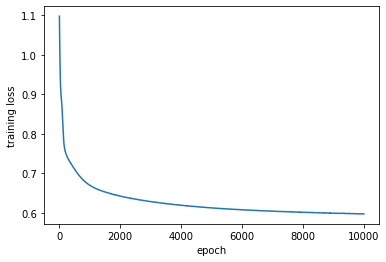

In [16]:
import matplotlib.pyplot as plt

# Plot training loss.
plt.plot(epoch_list, training_loss_list)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()